In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
df = pd.read_csv('CloudWatch_Traffic_Web_Attack.csv')
df.head()

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
3,30546,14278,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
4,6526,13892,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


In [10]:
df.columns

Index(['bytes_in', 'bytes_out', 'creation_time', 'end_time', 'src_ip',
       'src_ip_country_code', 'protocol', 'response.code', 'dst_port',
       'dst_ip', 'rule_names', 'observation_name', 'source.meta',
       'source.name', 'time', 'detection_types'],
      dtype='object')

In [11]:
# Remove duplicates
df = df.drop_duplicates()

In [12]:
# Convert date columns
df['creation_time'] = pd.to_datetime(df['creation_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df['time'] = pd.to_datetime(df['time'])

In [13]:
# Standardize country code
df['src_ip_country_code'] = df['src_ip_country_code'].str.upper()

print("✅ Data cleaned. Info:")
df.info()

✅ Data cleaned. Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   bytes_in             282 non-null    int64              
 1   bytes_out            282 non-null    int64              
 2   creation_time        282 non-null    datetime64[ns, UTC]
 3   end_time             282 non-null    datetime64[ns, UTC]
 4   src_ip               282 non-null    object             
 5   src_ip_country_code  282 non-null    object             
 6   protocol             282 non-null    object             
 7   response.code        282 non-null    int64              
 8   dst_port             282 non-null    int64              
 9   dst_ip               282 non-null    object             
 10  rule_names           282 non-null    object             
 11  observation_name     282 non-null    object             
 12  

In [14]:
# Create duration feature
df['duration_seconds'] = (df['end_time'] - df['creation_time']).dt.total_seconds()

In [15]:
# Scale numeric features
scaler = StandardScaler()
scaled = scaler.fit_transform(df[['bytes_in', 'bytes_out', 'duration_seconds']])
scaled_df = pd.DataFrame(scaled, columns=['scaled_bytes_in', 'scaled_bytes_out', 'scaled_duration_seconds'])

In [17]:
# One-hot encode country code
encoder = OneHotEncoder(sparse_output=False)
encoded = encoder.fit_transform(df[['src_ip_country_code']])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['src_ip_country_code']))

In [18]:
# Combine all
transformed_df = pd.concat([df, scaled_df, encoded_df], axis=1)
transformed_df.head()

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,...,scaled_bytes_in,scaled_bytes_out,scaled_duration_seconds,src_ip_country_code_AE,src_ip_country_code_AT,src_ip_country_code_CA,src_ip_country_code_DE,src_ip_country_code_IL,src_ip_country_code_NL,src_ip_country_code_US
0,5602,12990,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,...,-0.288219,-0.281223,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,30912,18186,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.33.6,US,HTTPS,200,443,10.138.69.97,...,-0.282108,-0.260804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,28506,13468,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,...,-0.282689,-0.279344,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,30546,14278,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,136.226.64.114,US,HTTPS,200,443,10.138.69.97,...,-0.282197,-0.276161,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,6526,13892,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,...,-0.287996,-0.277678,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


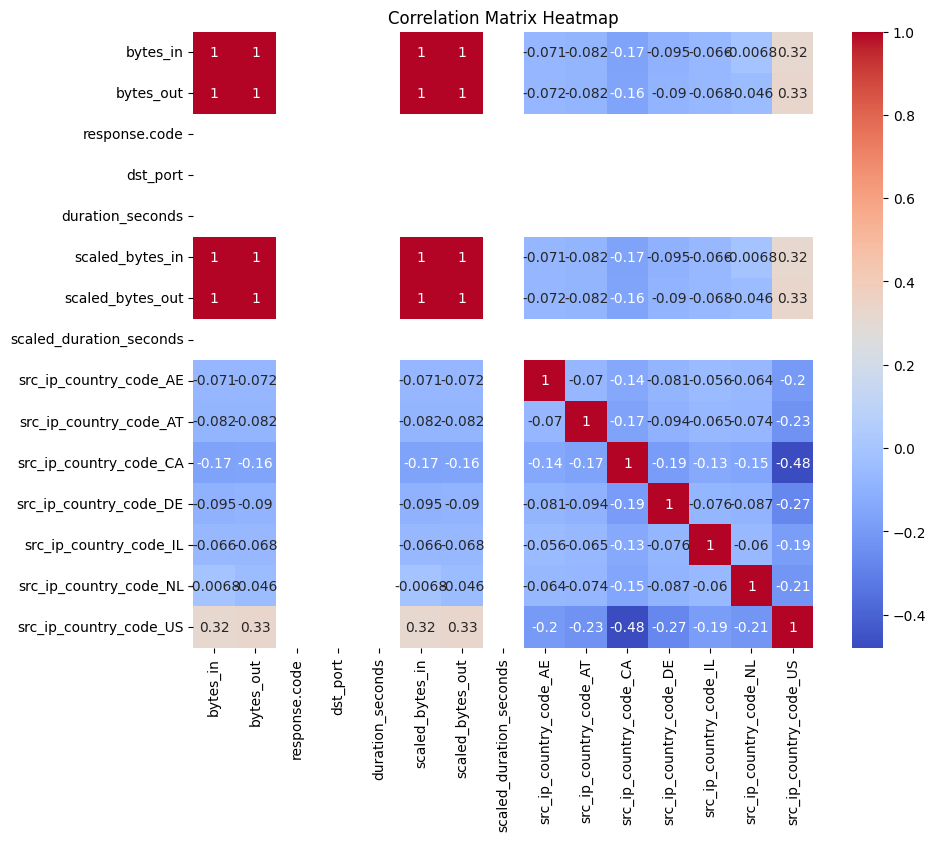

In [19]:
# Correlation matrix
numeric_df = transformed_df.select_dtypes(include=['float64', 'int64'])
corr = numeric_df.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

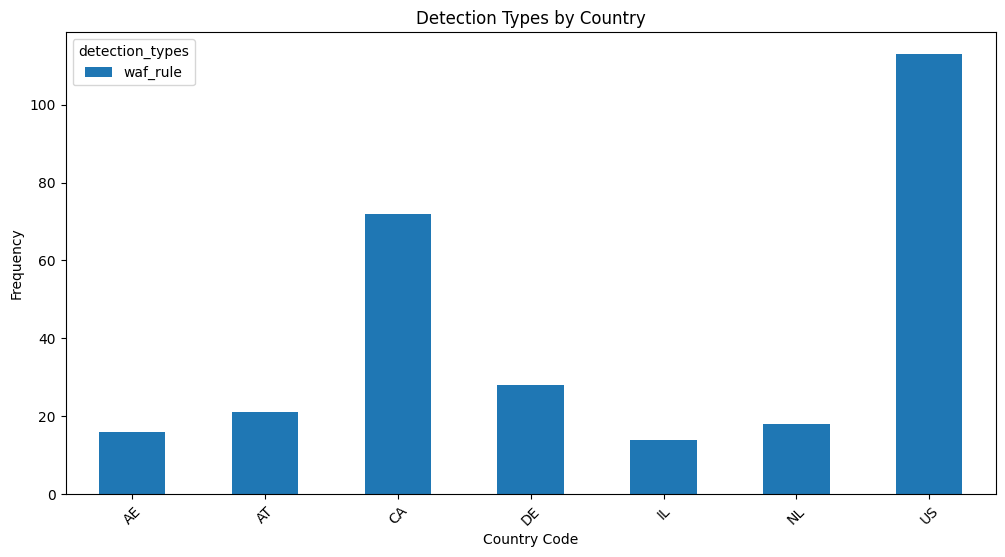

In [20]:
# Detection types by country code
detection_by_country = pd.crosstab(transformed_df['src_ip_country_code'], transformed_df['detection_types'])
detection_by_country.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('Detection Types by Country')
plt.xlabel('Country Code')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

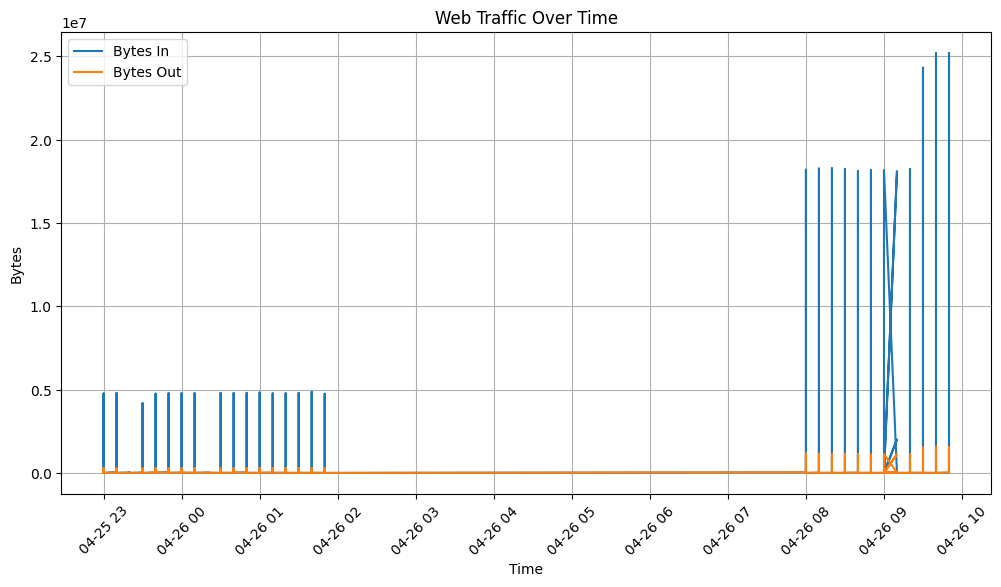

In [21]:
# Traffic trend over time
df.set_index('creation_time', inplace=True)
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['bytes_in'], label='Bytes In')
plt.plot(df.index, df['bytes_out'], label='Bytes Out')
plt.title('Web Traffic Over Time')
plt.xlabel('Time')
plt.ylabel('Bytes')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

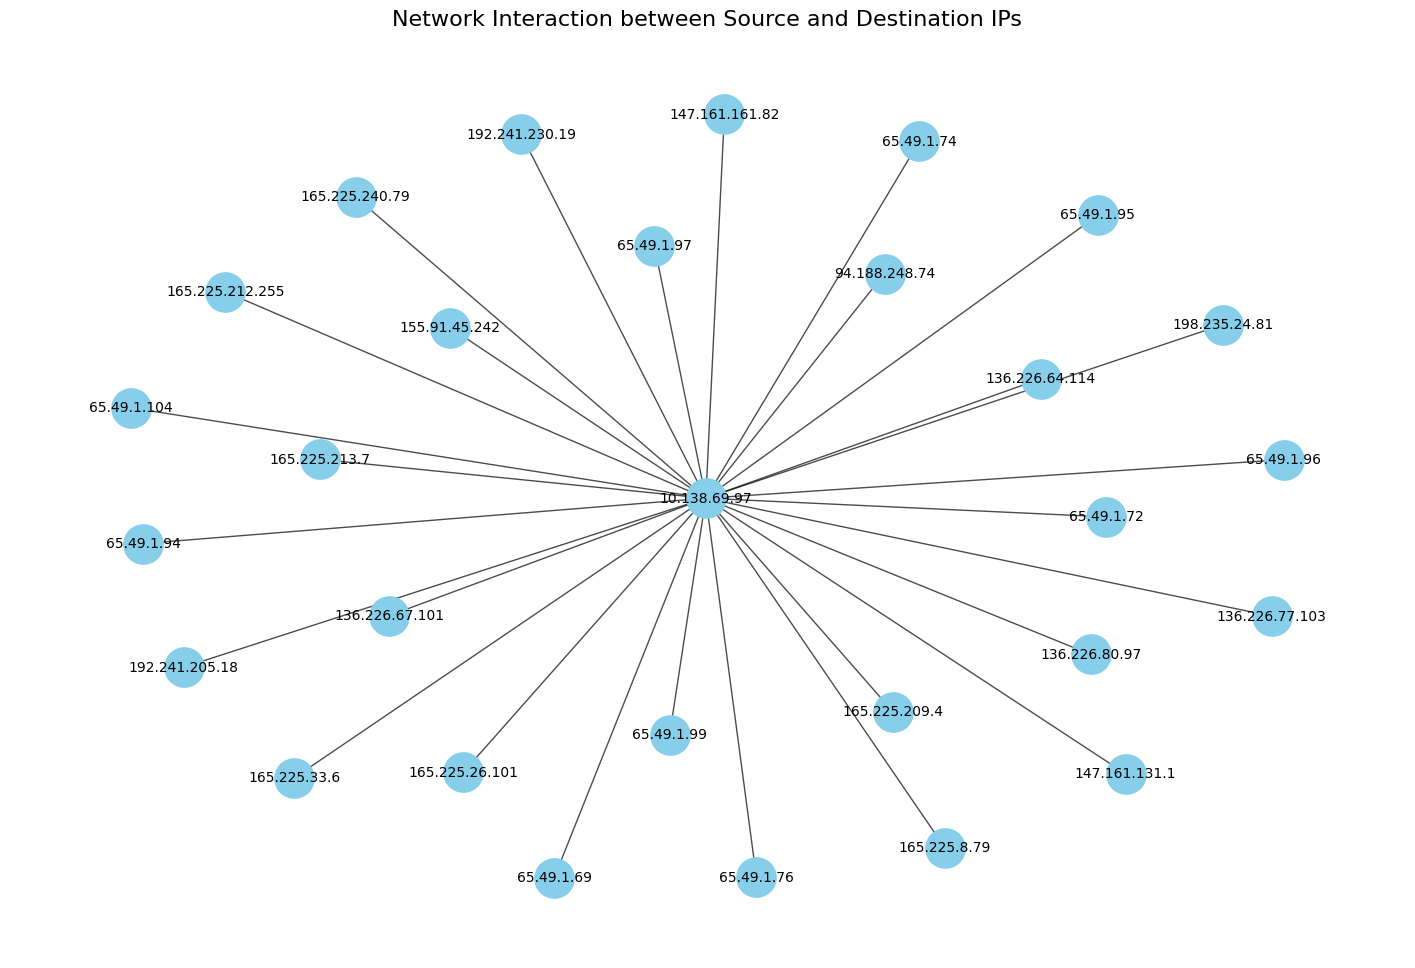

In [28]:
# Create the graph
G = nx.Graph()

# Add edges from source IP to destination IP
for idx, row in df.iterrows():   # make sure 'data' exists!
    G.add_edge(row['src_ip'], row['dst_ip'])

# Use spring layout for better spacing
pos = nx.spring_layout(G, k=0.3, seed=42)

plt.figure(figsize=(18, 12))
nx.draw_networkx_nodes(G, pos, node_size=800, node_color='skyblue')
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

plt.title('Network Interaction between Source and Destination IPs', fontsize=16)
plt.axis('off')
plt.show()


In [24]:
# Label suspicious
transformed_df['is_suspicious'] = (transformed_df['detection_types'] == 'waf_rule').astype(int)

# Features & target
X = transformed_df[['bytes_in', 'bytes_out', 'scaled_duration_seconds']]
y = transformed_df['is_suspicious']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Evaluate
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Random Forest Accuracy: 1.00

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        85

    accuracy                           1.00        85
   macro avg       1.00      1.00      1.00        85
weighted avg       1.00      1.00      1.00        85



Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.5532 - loss: 0.6846 - val_accuracy: 1.0000 - val_loss: 0.5910
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9827 - loss: 0.6015 - val_accuracy: 1.0000 - val_loss: 0.5373
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.5684 - val_accuracy: 1.0000 - val_loss: 0.4892
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - loss: 0.5253 - val_accuracy: 1.0000 - val_loss: 0.4445
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 0.4612 - val_accuracy: 1.0000 - val_loss: 0.4002
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 0.4204 - val_accuracy: 1.0000 - val_loss: 0.3555
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.3744 - val_accuracy: 1.0000 - val_loss: 0.3053
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 0.3136 - val_accuracy: 1.0000 - 

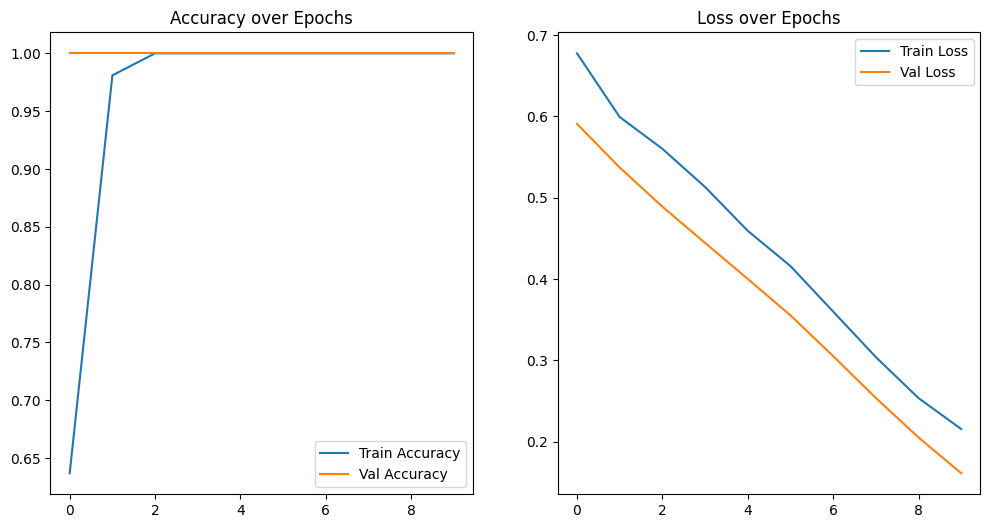

In [25]:
# Use same features, scale if needed
scaler_nn = StandardScaler()
X_train_scaled = scaler_nn.fit_transform(X_train)
X_test_scaled = scaler_nn.transform(X_test)

# Build NN
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=16, validation_split=0.2)

# Evaluate
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Neural Network Test Accuracy: {accuracy*100:.2f}%")

# Plot
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.show()